In [ ]:
import numpy as np          # For generating sine wave data
import tensorflow as tf     # For building and training the model
import matplotlib.pyplot as plt  # For plotting (optional but useful)
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Generate training data for sine wave
train_x = np.linspace(0, 2 * np.pi, 1000)  # 1000 values from 0 to 2π
train_y = np.sin(train_x)                 # sine of those values

# Reshape the data for training
train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)


In [ ]:
from sklearn.model_selection import train_test_split
train_x_, test_x_, train_y_, test_y_ = train_test_split(train_x, train_y, test_size = 0.2, random_state = 42)

In [ ]:
# Compute mean and std from training data only
mean = train_x_.mean()
std = train_x_.std()

# Apply normalization to both sets
x_train_scaled = (train_x_ - mean) / std
x_test_scaled = (test_x_ - mean) / std


In [ ]:
model = keras.Sequential()
model.add(layers.Input(shape=(1,)))
model.add(layers.Dense(10, activation = 'relu'))
model.add(layers.Dense(1))
model.compile(loss ='mean_squared_error', optimizer = 'adam', metrics = ['mae'])
train = model.fit(x_train_scaled, train_y_, epochs = 260, batch_size = 30)


Epoch 1/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4685 - mae: 0.6114
Epoch 2/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3571 - mae: 0.5271
Epoch 3/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2609 - mae: 0.4476
Epoch 4/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2093 - mae: 0.4040
Epoch 5/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1760 - mae: 0.3686
Epoch 6/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1593 - mae: 0.3525
Epoch 7/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1499 - mae: 0.3435
Epoch 8/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1529 - mae: 0.3448
Epoch 9/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1469 - mae: 0.3320  
Epoch 10/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 - mae: 0.3159 
Epoch 11/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 - mae: 0.3134 
Epoch 12/260
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1203 - mae: 0.2973 
Epoch 13/260
27/27 ━━━━━━━━━━━━━

In [ ]:
y_pred = model.predict(x_test_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mae = mean_absolute_error(test_y_, y_pred)
mse = mean_squared_error(test_y_, y_pred)
r2 = r2_score(test_y_, y_pred)
print(mae, mse, r2, end = '')



0.011561934559332717 0.00022672309101495349 0.9995603679934048

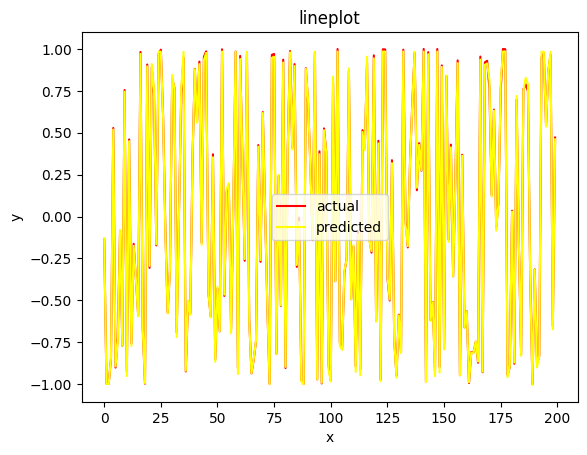

In [ ]:
plt.plot(test_y_, label = 'actual', color = 'red')
plt.plot(y_pred, label = 'predicted', color = 'yellow')
plt.title('lineplot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
model.save("sinwave.keras")

In [ ]:
model = tf.keras.models.load_model("sinwave.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open("sinwave.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp6thteinq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135570205596880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135570205598224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135570205598032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135570205596304: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
with open("sinwave.tflite", "rb") as f:
    tflite_model = f.read()

with open("sinwave_model.cc", "w") as f:
    f.write("const unsigned char sinwave_model[] = {")
    f.write(', '.join(hex(b) for b in tflite_model))
    f.write("};\n")
    f.write(f"const int sinwave_model_len = {len(tflite_model)};")


In [ ]:
import time
import numpy as np
from sklearn.metrics import mean_absolute_error

# 1. Model Size
with open("sinwave.tflite", "rb") as f:
    tflite_model = f.read()
print(f"Model Size: {len(tflite_model)/1024:.2f} KB")

# 2. Setup TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3. Test Accuracy
tflite_pred = []
for x in x_test_scaled:
    interpreter.set_tensor(input_details[0]['index'], x.reshape(1,1).astype(np.float32))
    interpreter.invoke()
    tflite_pred.append(interpreter.get_tensor(output_details[0]['index'])[0][0])

tflite_mae = mean_absolute_error(test_y_, tflite_pred)
print(f"TFLite MAE: {tflite_mae:.4f}")

# 4. Test Speed
start = time.time()
for _ in range(100):
    interpreter.set_tensor(input_details[0]['index'], x_test_scaled[0].reshape(1,1).astype(np.float32))
    interpreter.invoke()
speed = (time.time() - start) / 100 * 1000
print(f"Inference Speed: {speed:.3f} ms")

Model Size: 1.59 KB
TFLite MAE: 0.0116
Inference Speed: 0.005 ms


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
import os
cc_size = os.path.getsize("sinwave_model.cc")
print(f".cc file size: {cc_size} bytes")


.cc file size: 8905 bytes
